In [4]:
import copy
import os
import sys
from argparse import Namespace
from typing import *

import numpy as np
import tensordict.utils
import torch
import torch.nn as nn
from matplotlib import colors
from matplotlib import pyplot as plt
from tensordict import TensorDict
from transformers import GPT2Config, TransfoXLConfig

# This line needs to be added since some terminals will not recognize the current directory
os.chdir("..")
if os.getcwd() not in sys.path:
    sys.path.insert(0, os.getcwd())

from infrastructure import loader
from infrastructure import utils
from infrastructure.experiment import *
from infrastructure.settings import DEVICE
from infrastructure.utils import PTR
from model.convolutional import CnnPredictorLeastSquares
from model.base import Predictor
from model.sequential import RnnPredictorPretrainAnalytical
from model.transformer import GPT2InContextPredictor, TransformerXLInContextPredictor
from model.zero_predictor import ZeroPredictor
from system.linear_time_invariant import LinearSystemGroup, MOPDistribution

Could not import netCDF4's package ==> I/O will not be available in this format


/home/jovyan/.local/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Result processing
------------------------------------------------------------------------------------------------------------------------


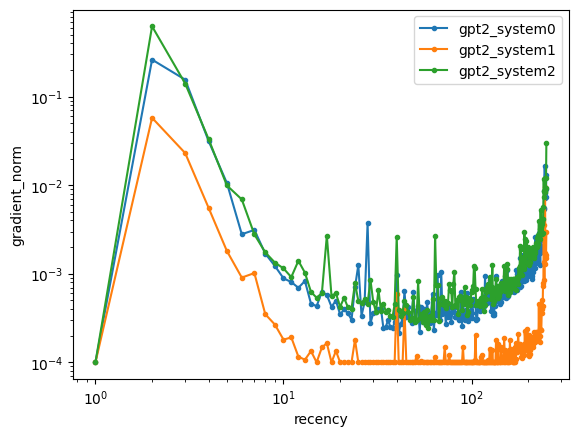

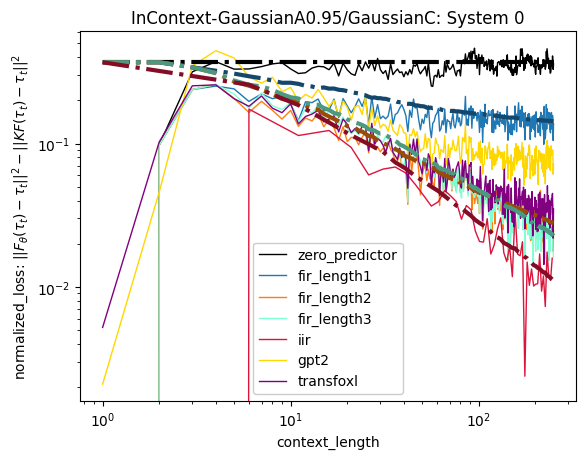

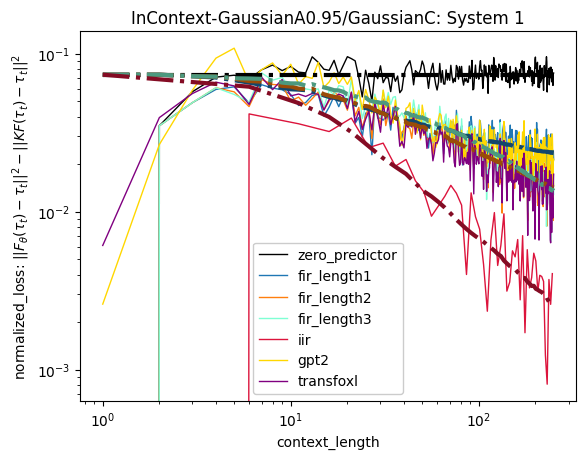

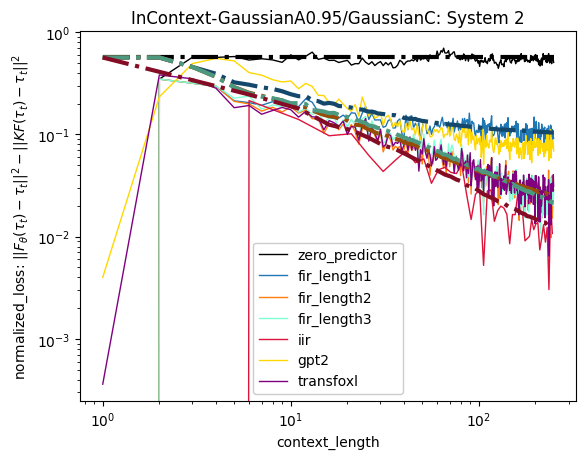

In [6]:
output_dir = "in_context"
output_fname = "result"

SHP = Namespace(S_D=10, I_D=1, O_D=5, input_enabled=False)

context_length = 250
n_train_systems = 40000
n_test_systems = 3
valid_dataset_size = 2000
test_dataset_size = 256

n_firs = 5
rnn_increment = 5

save_file = "sandbox/cdc_reconstruction_save.pt"
if os.path.exists(save_file):
    save = torch.load(save_file, map_location=DEVICE)

    systems, dataset, result_transformer, result_baseline_cnn, result_baseline_rnn = map(vars(save).__getitem__, (
        "systems",
        "dataset",
        "result_transformer",
        "result_baseline_cnn",
        "result_baseline_rnn"
    ))
else:
    """ Transformer experiment """
    exp_name_transformer = "CDCReconstruction_transformer"

    ARGS_TRANSFORMER = loader.generate_args(SHP)

    # SECTION: Transformer architecture hyperparameters
    d_embed = 256
    n_layer = 12
    n_head = 8
    d_inner = 4 * d_embed

    ARGS_TRANSFORMER.model.gpt2 = GPT2Config(
        n_positions=context_length,
        n_embd=d_embed,
        n_layer=n_layer,
        n_head=n_head,
        n_inner=d_inner,
        resid_pdrop=0.0, embd_pdrop=0.0, attn_pdrop=0.0, use_cache=False,
    )
    ARGS_TRANSFORMER.model.transformerxl = TransfoXLConfig(
        d_model=d_embed,
        d_embed=d_embed,
        n_layer=n_layer,
        n_head=n_head,
        d_head=d_embed // n_head,
        d_inner=d_inner,
        dropout=0.0,
    )

    # SECTION: Dataset hyperparameters
    ARGS_TRANSFORMER.dataset.train = Namespace(
        dataset_size=1,
        total_sequence_length=context_length,
        system=Namespace(
            n_systems=n_train_systems,
            distribution=MOPDistribution("gaussian", "gaussian", 0.1, 0.1)
        )
    )
    ARGS_TRANSFORMER.dataset.valid = Namespace(
        dataset_size=valid_dataset_size,
        total_sequence_length=valid_dataset_size * context_length,
        system=Namespace(
            n_systems=n_test_systems
        )
    )
    ARGS_TRANSFORMER.dataset.test = Namespace(
        dataset_size=test_dataset_size,
        total_sequence_length=test_dataset_size * context_length,
        system=Namespace(
            n_systems=n_test_systems
        )
    )

    # SECTION: Training hyperparameters
    del ARGS_TRANSFORMER.train.warmup_duration
    ARGS_TRANSFORMER.train.epochs = 40000
    ARGS_TRANSFORMER.train.subsequence_length = context_length
    ARGS_TRANSFORMER.train.batch_size = 32
    ARGS_TRANSFORMER.train.iterations_per_epoch = 1

    ARGS_TRANSFORMER.train.optim_type = "Adam"
    ARGS_TRANSFORMER.train.max_lr = 3e-4
    ARGS_TRANSFORMER.train.lr_decay = 1.0
    ARGS_TRANSFORMER.train.weight_decay = 1e-2

    ARGS_TRANSFORMER.experiment.n_experiments = 1
    ARGS_TRANSFORMER.experiment.ensemble_size = 1
    ARGS_TRANSFORMER.experiment.exp_name = exp_name_transformer
    ARGS_TRANSFORMER.experiment.metrics = set() # {"validation"}

    configurations_transformer = [
        ("model", {
            "model.model": [GPT2InContextPredictor, TransformerXLInContextPredictor],
        })
    ]

    result_transformer, dataset = run_experiments(
        ARGS_TRANSFORMER, configurations_transformer, {
            "dir": output_dir,
            "fname": output_fname
        }, save_experiment=True
    )

    systems = utils.multi_map(
        lambda lsg: LinearSystemGroup(lsg.state_dict(), SHP.input_enabled),
        torch.load(f"output/{output_dir}/{exp_name_transformer}/testing/systems.pt", map_location=DEVICE)["test"], dtype=LinearSystemGroup
    )


    """ Baseline experiment setup """
    exp_name_baseline_cnn = "CDCReconstruction_baseline_cnn"
    exp_name_baseline_rnn = "CDCReconstruction_baseline_rnn"

    for _exp_name_baseline in (exp_name_baseline_cnn, exp_name_baseline_rnn):
        os.makedirs(f"output/{output_dir}/{_exp_name_baseline}/training", exist_ok=True)
        os.makedirs(f"output/{output_dir}/{_exp_name_baseline}/testing", exist_ok=True)


        if not all(map(os.path.exists, (
            f"output/{output_dir}/{_exp_name_baseline}/training/systems.pt",
            f"output/{output_dir}/{_exp_name_baseline}/testing/systems.pt"
        ))):
            baseline_systems = utils.multi_map(lambda lsg: LinearSystemGroup(lsg.td().permute(1, 0), SHP.input_enabled), systems, dtype=LinearSystemGroup)
            torch.save({
                "train": baseline_systems
            }, f"output/{output_dir}/{_exp_name_baseline}/training/systems.pt")
            torch.save({
                "test": baseline_systems
            }, f"output/{output_dir}/{_exp_name_baseline}/testing/systems.pt")


        if not all(map(os.path.exists, (
            f"output/{output_dir}/{_exp_name_baseline}/training/dataset.pt",
            f"output/{output_dir}/{_exp_name_baseline}/testing/dataset.pt"
        ))):
            baseline_dataset = utils.multi_map(lambda dataset_: PTR(dataset_.obj.permute(2, 3, 0, 1, 4)), dataset, dtype=PTR)
            torch.save({
                "train": baseline_dataset,
                "valid": baseline_dataset
            }, f"output/{output_dir}/{_exp_name_baseline}/training/dataset.pt")
            torch.save({
                "test": baseline_dataset,
            }, f"output/{output_dir}/{_exp_name_baseline}/testing/dataset.pt")



    """ CNN Experiment """
    ARGS_BASELINE_CNN = loader.generate_args(SHP)
    ARGS_BASELINE_CNN.dataset.train = Namespace(
        dataset_size=1,
        system=Namespace(
            n_systems=1,
            distribution=MOPDistribution("gaussian", "gaussian", 0.1, 0.1)
        )
    )
    ARGS_BASELINE_CNN.dataset.valid = ARGS_BASELINE_CNN.dataset.test = Namespace(
        total_sequence_length=context_length
    )
    ARGS_BASELINE_CNN.experiment.n_experiments = n_test_systems
    ARGS_BASELINE_CNN.experiment.ensemble_size = test_dataset_size
    ARGS_BASELINE_CNN.experiment.metrics = {"validation_analytical"}

    # SECTION: Make a copy for RNN args after setting shared parameters
    ARGS_BASELINE_RNN = copy.deepcopy(ARGS_BASELINE_CNN)

    # SECTION: Set CNN exclusive hyperparameters
    ARGS_BASELINE_CNN.model.ridge = 1.0
    ARGS_BASELINE_CNN.experiment.exp_name = exp_name_baseline_cnn

    configurations_baseline_cnn = [
        ("model", {
            "model.ir_length": [*range(1, n_firs + 1)],
        }),
        ("total_trace_length", {
            "model.model": [ZeroPredictor] + [CnnPredictorLeastSquares] * (context_length - 1),
            "dataset.train.total_sequence_length": [*range(context_length),]
        })
    ]

    result_baseline_cnn, _ = run_experiments(
        ARGS_BASELINE_CNN, configurations_baseline_cnn, {
            "dir": output_dir,
            "fname": output_fname
        }, save_experiment=True
    )



    """ RNN Experiment """
    # SECTION: Set RNN exclusive hyperparameters
    ARGS_BASELINE_RNN.model.S_D = SHP.S_D
    ARGS_BASELINE_RNN.train.optim_type = "GD"
    ARGS_BASELINE_RNN.train.max_lr = 1e-3
    ARGS_BASELINE_RNN.train.epochs = 1200
    ARGS_BASELINE_RNN.experiment.exp_name = exp_name_baseline_rnn

    configurations_baseline_rnn = [
        ("total_trace_length", {
            "model.model": [ZeroPredictor] + [RnnPredictorPretrainAnalytical] * ((context_length - 1) // rnn_increment),
            "dataset.train.total_sequence_length": [*range(0, context_length, rnn_increment),]
        })
    ]

    result_baseline_rnn, _ = run_experiments(
        ARGS_BASELINE_RNN, configurations_baseline_rnn, {
            "dir": output_dir,
            "fname": output_fname
        }, save_experiment=True
    )


    # SECTION: Save the collected experiment results
    save = Namespace(
        systems=systems,
        dataset=dataset,
        result_transformer=result_transformer,
        result_baseline_cnn=result_baseline_cnn,
        result_baseline_rnn=result_baseline_rnn
    )
    torch.save(save, save_file)


M_transformer = get_metric_namespace_from_result(result_transformer)
M_baseline_cnn = get_metric_namespace_from_result(result_baseline_cnn)
M_baseline_rnn = get_metric_namespace_from_result(result_baseline_rnn)



""" Result processing """
print("Result processing" + "\n" + "-" * 120)
systems = LinearSystemGroup(systems.values[()].td().squeeze(0), SHP.input_enabled)
dataset = dataset.values[()].obj.squeeze(1).squeeze(0)

def loss(observation_estimation: torch.Tensor) -> torch.Tensor:
    return (dataset["observation"] - observation_estimation).norm(dim=-1) ** 2

with torch.set_grad_enabled(False):
    zero_predictor_al = utils.batch_trace(systems.S_observation_inf)
    zero_predictor_l = loss(torch.zeros_like(dataset["observation"]))
    il = utils.batch_trace(systems.S_prediction_err_inf)
    eil = loss(dataset["target"])


    # [n_experiments x ensemble_size x n_test_systems x test_dataset_size x context_length x O_D]
    # -> [n_test_systems x test_dataset_size x context_length x O_D]
    gpt2_output, transfoxl_output = M_transformer.output.observation_estimation.squeeze(2).squeeze(1)
    # -> [n_test_systems x test_dataset_size x context_length]
    gpt2_l, transfoxl_l = loss(gpt2_output), loss(transfoxl_output)

    
    # [n_firs x train.sequence_length x n_test_systems x test_dataset_size x n_experiments x ensemble_size x context_length x O_D]
    # -> [n_firs x train.sequence_length x n_test_systems x test_dataset_size x context_length x O_D]
    # -> [n_firs x n_test_systems x test_dataset_size x O_D x context_length]
    # -> [n_firs x n_test_systems x test_dataset_size x context_length x O_D]
    cnn_output = torch.diagonal(M_baseline_cnn.output.observation_estimation.squeeze(5).squeeze(4), dim1=1, dim2=4).transpose(3, 4)
    # -> [n_firs x n_test_systems x test_dataset_size x context_length]
    cnn_l = loss(cnn_output)
    # [n_firs x context_length x n_test_systems x test_dataset_size x n_experiments x ensemble_size]
    # -> [n_firs x context_length x n_test_systems x test_dataset_size]
    # -> [n_firs x n_test_systems x test_dataset_size x context_length]
    cnn_al = M_baseline_cnn.al.squeeze(5).squeeze(4).permute(0, 2, 3, 1)


    # [train.sequence_length x n_test_systems x test_dataset_size x n_experiments x ensemble_size x context_length x O_D]
    # -> [train.sequence_length x n_test_systems x test_dataset_size x context_length x O_D]
    # -> [train.sequence_length x n_test_systems x test_dataset_size x O_D]
    # -> [n_test_systems x test_dataset_size x train.sequence_length x O_D]
    rnn_sequence_lengths = [*range(0, context_length, rnn_increment),]
    rnn_output = M_baseline_rnn.output.observation_estimation.squeeze(4).squeeze(3)[torch.arange(len(rnn_sequence_lengths)), :, :, torch.tensor(rnn_sequence_lengths)].permute(1, 2, 0, 3)
    # [train.sequence_length x n_test_systems x test_dataset_size x n_experiments x ensemble_size]
    # -> [train.sequence_length x n_test_systems x test_dataset_size]
    # -> [n_test_systems x test_dataset_size x train.sequence_length]
    rnn_al = M_baseline_rnn.al.squeeze(4).squeeze(3).permute(1, 2, 0)


    rnn_indices = torch.tensor(rnn_sequence_lengths)
    padded_rnn_output = torch.zeros((n_test_systems, test_dataset_size, context_length, SHP.O_D))
    padded_rnn_output[:, :, rnn_indices] = rnn_output
    # -> [n_test_systems x test_dataset_size x context_length]
    rnn_l = loss(padded_rnn_output)[:, :, rnn_indices]



# SECTION: Transformer impulse response
def cd(t: torch.Tensor) -> torch.Tensor:
    return t.cpu().detach()

def to_rgb(c: Any) -> np.ndarray:
    return np.array(colors.to_rgb(c))


(gpt2_rm, gpt2_td), (transfoxl_rm, transfoxl_td) = get_result_attr(result_transformer, "learned_kfs")
gpt2_td = gpt2_td.squeeze(1).squeeze(0)
transfoxl_td = transfoxl_td.squeeze(1).squeeze(0)

dataset_parameter = TensorDict.from_dict(dataset, batch_size=dataset.shape)
dataset_parameter["observation"] = nn.Parameter(dataset["observation"])

with torch.set_grad_enabled(True):
    gpt2_response = Predictor.gradient(gpt2_rm, gpt2_td, dataset_parameter, split_size=1 << 17)
    transfoxl_response = Predictor.gradient(transfoxl_rm, transfoxl_td, dataset_parameter, split_size=1 << 17)

gpt2_gn = (gpt2_response["observation"].norm(dim=-1) ** 2).mean(dim=1)
for sys_idx in range(n_test_systems):
    plt.plot(
        cd(torch.arange(1, context_length + 1)),
        cd(torch.flip(gpt2_gn[sys_idx].clamp_min(1e-4), dims=(0,))),
        marker=".", label=f"gpt2_system{sys_idx}"
    )

plt.xscale("log")
plt.xlabel("recency")
plt.yscale("log")
plt.ylabel("gradient_norm")

plt.legend()
plt.show()



# SECTION: Plotting code
def plot(system_idx: int) -> None:
    x = torch.arange(1, context_length + 1)

    def plot_analytical(
            l: torch.Tensor, color,
            indices: torch.Tensor = torch.arange(context_length, dtype=torch.int),
            error_bars: bool = False, **kwargs
    ) -> None:
        assert l.ndim in (2, 3), f"Can only plot analytical loss of ndim 2 or 3 but got {l.ndim}."
        assert l.shape[0] == n_test_systems, f"First dimension of loss must match number of test systems."
        plt_kwargs = {
            "color": 0.6 * to_rgb(color),
            "linewidth": 3,
            "linestyle": "-."
        }
        plt_kwargs.update(kwargs)
        x_ = x[indices]

        l = (l - tensordict.utils.expand_as_right(il, l))[system_idx]
        if l.ndim == 1:
            plt.plot(cd(x_), cd(l), **plt_kwargs, zorder=12)
        else:
            plt.plot(cd(x_), cd(l.median(dim=0).values), zorder=12, **plt_kwargs)
            if error_bars:
                plt.fill_between(
                    cd(x_), *cd(torch.quantile(l, torch.tensor([0.25, 0.75]), dim=0)),
                    alpha=0.1, **plt_kwargs
                )

    def plot_empirical(
            l: torch.Tensor, name: str, color,
            indices: torch.Tensor = torch.arange(context_length, dtype=torch.int),
            error_bars: bool = False, **kwargs
    ) -> None:
        assert l.ndim == 3, f"Empirical loss must be ndim 3 but got {l.ndim}."
        assert l.shape[0] == n_test_systems, f"First dimension of loss must match number of test systems."
        plt_kwargs = {
            "color": to_rgb(color),
            "linewidth": 1
        }
        plt_kwargs.update(kwargs)
        x_ = x[indices]

        l = (l - eil[:, :, indices])[system_idx]
        plt.plot(cd(x_), cd(l.mean(dim=0)), label=name, **plt_kwargs)
        if error_bars:
            plt.fill_between(
                cd(x_), *cd(torch.quantile(l, torch.tensor([0.25, 0.75]), dim=0)),
                alpha=0.1, **plt_kwargs
            )

    # SECTION: Plot zero predictor
    plot_empirical(zero_predictor_l, "zero_predictor", "black")
    plot_analytical(zero_predictor_al[:, None].expand(n_test_systems, context_length), "black")

    # SECTION: Plot CNN baseline
    c_list = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    c_list[2] = "aquamarine"
    for fir_length in range(3):
        plot_empirical(cnn_l[fir_length], f"fir_length{fir_length + 1}", c_list[fir_length])
        plot_analytical(cnn_al[fir_length], c_list[fir_length])

    # SECTION: Plot RNN baseline
    plot_empirical(rnn_l, "iir", "crimson", indices=rnn_indices)
    plot_analytical(rnn_al, "crimson", indices=rnn_indices)

    # SECTION: Plot transformers
    plot_empirical(gpt2_l, "gpt2", "gold", error_bars=False, zorder=2)
    plot_empirical(transfoxl_l, "transfoxl", "purple", error_bars=False, zorder=2)

    plt.title(f"InContext-GaussianA0.95/GaussianC: System {system_idx}")
    plt.xscale("log")
    plt.xlabel("context_length")
    plt.yscale("log")
    plt.ylabel(r'normalized_loss: $|| F_\theta(\tau_t) - \tau_t ||^2 - || KF(\tau_t) - \tau_t ||^2$')

    plt.legend(framealpha=1.0)
    plt.show()

for sys_idx in range(n_test_systems):
    plot(sys_idx)